#### Plots standards des données de bruit sismique

> Ce Notebook créé les graphiques de base pour étudier le bruit d'une station donnée.

---
## Importation des modules

In [1]:
%matplotlib inline

import datetime
import os
from glob import glob

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import tqdm.notebook as tqdm
import warnings

from obspy import UTCDateTime, read
from obspy.clients.fdsn import Client
from obspy.clients.fdsn.client import FDSNNoDataException
from obspy.signal import PPSD
from obspy.signal.spectral_estimation import get_nlnm, get_nhnm
from obspy.imaging.cm import pqlx

%load_ext autoreload
%autoreload 2
from seismic_noise import *
import seismosocialdistancing

---
## 1. Initialisation des paramètres initiaux

In [4]:
### Paramètres généraux
load_data = False              # Recalculer les PPSDs et le déplacement RMS
freqs = [(4.0,14.0)]          # Bandes de fréquences à étudier 
st_name = ["FR.STR.00.HHZ", "FR.CURIE.00.HHZ"]  # Station à étudier
time_zone = "Europe/Brussels"
noise_input_data = "/media/flavien/Stockage/SeismicNoiseData/"
PPSD_FOLDER  = "/media/flavien/Stockage/SeismicNoiseData/PPSD"
DRMS_FOLDER  = "/media/flavien/Stockage/SeismicNoiseData/DRMS"
MSEED_FOLDER = "/media/flavien/Stockage/SeismicNoiseData/MSEED"
timeseries_data = "Files/noise_timeseries/"
start = UTCDateTime("2020-01-01")    # Start Time
end = UTCDateTime("2020-12-31")      # End Time
datelist = pd.date_range(start.datetime, min(end, UTCDateTime()).datetime, freq="D")

---
##  2. Récupération des PPSDs

In [6]:
ppsds = {}

for station_str in st_name:
    for day in datelist:
        date_str = day.strftime("%Y-%m-%d")
        file_pattern = "{}/{}/{}_*.npz".format(PPSD_FOLDER, station_str, date_str)
        pbar.set_description("Reading data")

        for file in glob(file_pattern):
            mseedid = file.replace(".npz", "").split("_")[-1]

            if mseedid not in ppsds:
                ppsds[mseedid] = PPSD.load_npz(file, allow_pickle=True)
            else:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    ppsds[mseedid].add_npz(file, allow_pickle=True)

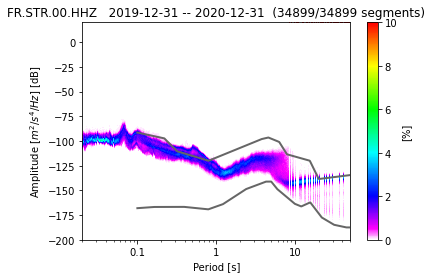

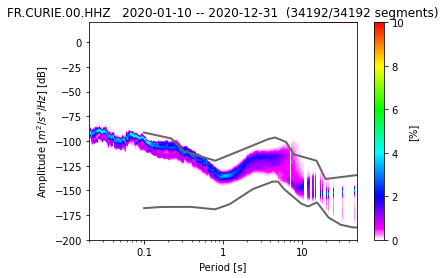

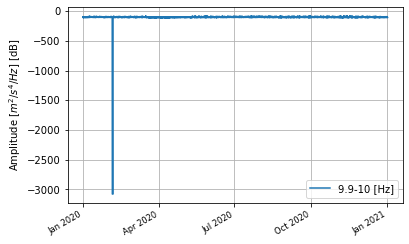

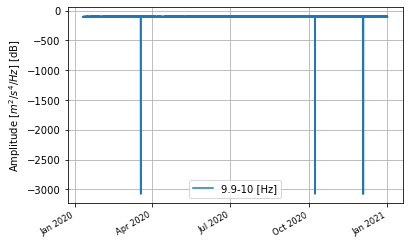

In [7]:
[ppsd.plot(max_percentage=10, grid=False, period_lim=(0.02,50), show_coverage=False, cmap=pqlx) for mseedid, ppsd in ppsds.items()]
[ppsd.plot_temporal(0.10) for mseedid, ppsd in ppsds.items()]
if False : [ppsd.plot_spectrogram(clim=(-160,-100), grid=False) for mseedid, ppsd in ppsds.items()]
plt.show()

---
## 3. Récupération du déplacement RMS

In [8]:
dRMS = {}
for mseedid, ppsd in tqdm.tqdm(ppsds.items()):
    file = DRMS_FOLDER + "/" + mseedid + ".csv"
    df = pd.read_csv(file, index_col=0)
    df.index = pd.to_datetime(df.index)
    dRMS[mseedid] = df
dRMS

100%|██████████| 2/2 [00:00<00:00, 32.97it/s]


{'FR.STR.00.HHZ':                                 4.0-14.0
 2019-12-31 23:29:59.000001  7.370956e-09
 2019-12-31 23:44:59.000001  7.251324e-09
 2019-12-31 23:59:59.000001  7.395703e-09
 2020-01-01 00:14:59.000001  8.260978e-09
 2020-01-01 00:29:59.000001  8.331614e-09
 ...                                  ...
 2021-01-01 22:59:59.000000  5.535127e-09
 2021-01-01 23:14:59.000000  6.030583e-09
 2021-01-01 23:29:59.000000  5.382156e-09
 2021-01-01 23:44:59.000000  4.105546e-09
 2021-01-01 23:59:59.000000  4.055108e-09
 
 [34995 rows x 1 columns],
 'FR.CURIE.00.HHZ':                              4.0-14.0
 2020-01-10 19:35:23.130  9.153767e-09
 2020-01-10 19:50:23.130  9.048457e-09
 2020-01-10 20:05:23.130  9.203135e-09
 2020-01-10 20:20:23.130  9.000162e-09
 2020-01-10 20:35:23.130  8.662537e-09
 ...                               ...
 2021-01-01 22:59:59.000  7.423254e-09
 2021-01-01 23:14:59.000  6.962178e-09
 2021-01-01 23:29:59.000  6.909846e-09
 2021-01-01 23:44:59.000  5.047647e-09
 2

/media/flavien/Développement/seismic-noise/seismosocialdistancing.py:726: FutureWarning: tshift is deprecated and will be removed in a future version. Please use shift instead.
  rs = rs.resample("1D" ).median().tshift(12, "H")


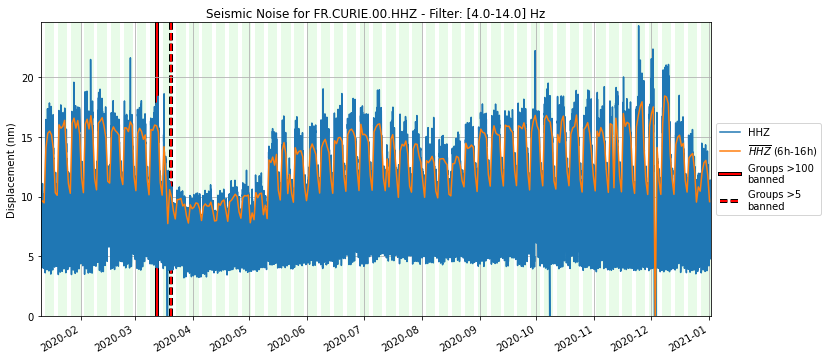

/media/flavien/Développement/seismic-noise/seismosocialdistancing.py:726: FutureWarning: tshift is deprecated and will be removed in a future version. Please use shift instead.
  rs = rs.resample("1D" ).median().tshift(12, "H")


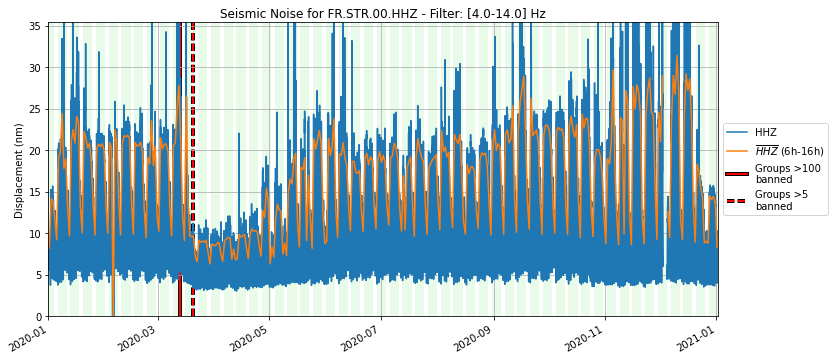

In [9]:
args = {'band':"4.0-14.0",       # might be None or commented ("4.0-14.0" per default) or any of the tupples in freqs
        'time_zone':time_zone,   # required for clockplots
        'logo':None,             # might be None or commented
        'unit':'nm'
       }
seismosocialdistancing.plot(dRMS,
                            type='timeseries',
                            **args)

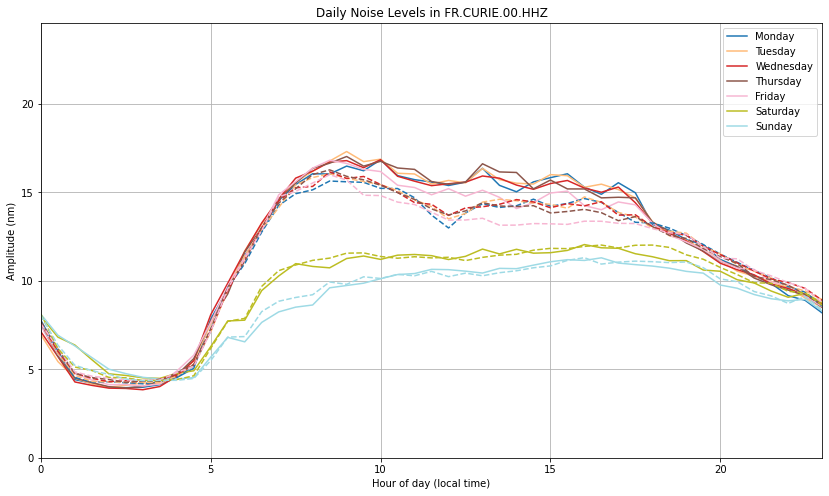

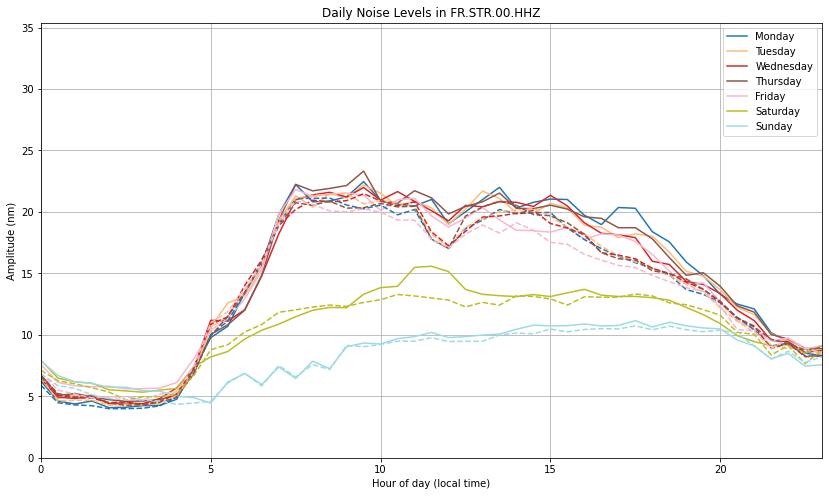

In [10]:
seismosocialdistancing.plot(dRMS,
                            type='dailyplots',
                            **args)

/media/flavien/Développement/seismic-noise/seismosocialdistancing.py:606: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["%.2g %s" %(i,unit) for i in ax.get_yticks()], fontsize=7)
/media/flavien/Développement/seismic-noise/seismosocialdistancing.py:606: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["%.2g %s" %(i,unit) for i in ax.get_yticks()], fontsize=7)


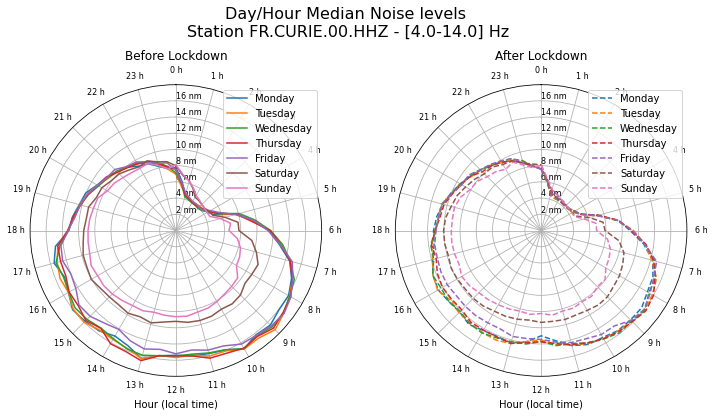

/media/flavien/Développement/seismic-noise/seismosocialdistancing.py:606: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["%.2g %s" %(i,unit) for i in ax.get_yticks()], fontsize=7)
/media/flavien/Développement/seismic-noise/seismosocialdistancing.py:606: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["%.2g %s" %(i,unit) for i in ax.get_yticks()], fontsize=7)


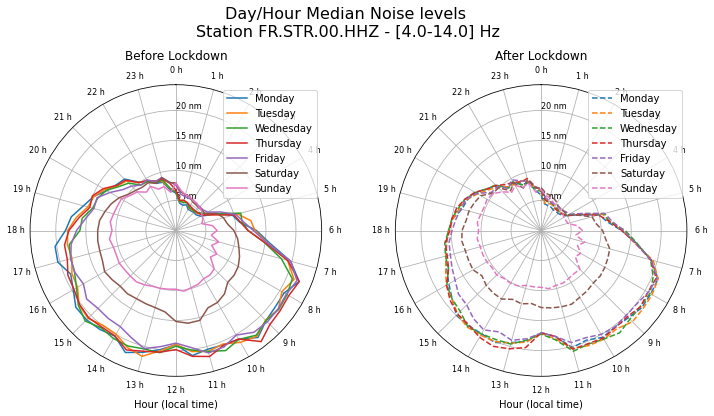

In [11]:
seismosocialdistancing.plot(dRMS,
                            type='clockplots',
                            **args)

In [12]:
seismosocialdistancing.plot(dRMS,
                            type='clockmaps',
                            **args)

ValueError: Index contains duplicate entries, cannot reshape

In [ ]:
seismosocialdistancing.plot(dRMS,
                            type='gridmaps',
                            **args)